**Question 6.1 Derivation of Weight Update Steps**

1) Ridge Regression Function (as defined in Module 2 Chapter 4 Page 9)  
    $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi(x_n))^2 + \frac{\lambda}{2} w^T . w$  
    
  
2) Derivation of the above function to obtain gradient (derive function wrt W)  
    $\nabla E(w) = \sum_{n=1}^{N} (w^T \phi(x_n) - t_n) \phi(x_n) + \lambda w$  
    
3) SGD weight update rule (as defined in Module 2 Chapter 2 Page 7)  
    $w_{n} = w_{n-1} - \eta \nabla E(w_{n-1})$
    
4) Putting it all together, we can get the following formula for weight update using SGD  

    $w_n = w_{n-1} - \eta \left[ (w_{n-1}^T \phi(x_n) - t_n) \phi(x_n) + \lambda w_{n-1} \right]$





In [107]:
# SGD Class Adpater from Activity 2.1 of Module 2
class SGDRidgeRegressor:

    def __init__(self, batch_size=1, eta=0.01, tau_max=1000, epsilon=0.00001, random_state=None, lam = 0.1):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        self.lam = lam
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            grad = (x[idx].dot(self.w_[tau-1])-y[idx] + (self.lam * self.w_[tau-1]))/ self.batch_size
            self.w_[tau] = self.w_[tau-1] - self.eta*grad
            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon:
                break
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)


**Question 6.3 L2 Regularisaton training and testing errors**

In [104]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return np.sin(5*np.pi*x)/(1+2*x)

def make_additive_noise_data(n, f, a, b, noise=0.1**0.5, random_state=None):
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y

In [114]:
def plot_function(f, a, b, models=[], data=None, ax=None, ax_labels=True, legend=True):
    ax = plt.gca() if ax is None else ax
    xx = np.linspace(a, b, 200).reshape(-1, 1)
    if len(models)==1:
        ax.fill_between(xx.squeeze(), f(xx).squeeze(), models[0].predict(xx).squeeze(), alpha=0.3)
        ax.plot(xx, models[0].predict(xx), label='$y$')
    if len(models) > 1:
        for model in models: ax.plot(xx, model.predict(xx), color='gray', alpha=0.5)
    ax.plot(xx, f(xx), color='black', label='$f$')
    if data is not None:
        x, y = data
        ax.scatter(x, y, marker='.', color='black', label='data')
    if ax_labels:
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
    if legend: ax.legend()
    ax.margins(x=0)

In [59]:
class PolynomialFeatures:

    def __init__(self, degree):
        self.degree = degree

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        output = []
        for i in range(0, self.degree+1):
            column = x**i
            output.append(column)
        return np.column_stack(output)

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x, y)

In [149]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from numpy import random

poly = PolynomialFeatures(5)
lambda_choices = np.geomspace(10**-10,0.1, 101, endpoint=True)
models = []
reps = 10
train_mse = [[] for i in range (len(lambda_choices))]
test_mse = [[] for i in range (len(lambda_choices))]

for rep in range (10):
    x_train, y_train = make_additive_noise_data(20, f, -0.3, 0.3, random_state=2)
    x_test, y_test = make_additive_noise_data(20, f, -0.3, 0.3, random_state=1)
    
    for i in range (len(lambda_choices)):
        
        transformation_then_ridge = make_pipeline(poly, SGDRidgeRegressor(lam = lambda_choices[i]))
        transformation_then_ridge.fit(x_train, y_train)
        
        y_train_pred = transformation_then_ridge.predict(x_train)
        y_test_pred = transformation_then_ridge.predict(x_test)
        
        train_mse[i].append(mean_squared_error(y_train, y_train_pred))
        test_mse[i].append(mean_squared_error(y_test, y_test_pred))
    
train_mse_mean = np.array([np.mean(mse) for mse in train_mse])
test_mse_mean = np.array([np.mean(mse) for mse in test_mse])    

# Plot the mean squared errors on log-log scale plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_choices, train_mse_mean, label='Training MSE', color='blue')
plt.plot(lambda_choices, test_mse_mean, label='Testing MSE', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log lambda')
plt.ylabel('log mean squared error')
plt.title('Mean Squared Errors vs. Log Lambda')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

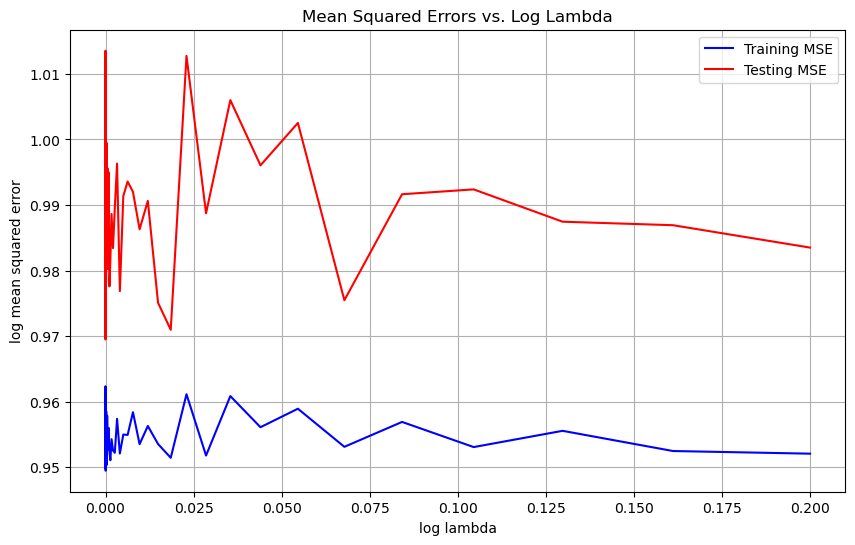

In [177]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(5)
lambda_choices = np.geomspace(10**-10,0.2, 100, endpoint=True)
models = []
reps = 10
train_mse = [[] for i in range (len(lambda_choices))]
test_mse = [[] for i in range (len(lambda_choices))]

for rep in range (10):
    
    x_data, y_data = make_additive_noise_data(40, f, -0.3, 0.3, random_state=1)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=True ,random_state=1)
    
    for i in range (len(lambda_choices)):
        
        transformation_then_ridge = make_pipeline(poly, SGDRidgeRegressor(lam = lambda_choices[i]))
        transformation_then_ridge.fit(x_train, y_train)
        
        y_train_pred = transformation_then_ridge.predict(x_train)
        y_test_pred = transformation_then_ridge.predict(x_test)
        
        train_mse[i].append(mean_squared_error(y_train, y_train_pred))
        test_mse[i].append(mean_squared_error(y_test, y_test_pred))
    
train_mse_mean = np.array([np.mean(mse) for mse in train_mse])
test_mse_mean = np.array([np.mean(mse) for mse in test_mse])    

# Plot the mean squared errors on log-log scale plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_choices, train_mse_mean, label='Training MSE', color='blue')
plt.plot(lambda_choices, test_mse_mean, label='Testing MSE', color='red')
plt.xlabel('log lambda')
plt.ylabel('log mean squared error')
plt.title('Mean Squared Errors vs. Log Lambda')
plt.legend()
plt.grid(True)
plt.show()
